# Data import

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy

Helper functions

In [2]:
def split_profession(str):
    return str.split(',')

def cast_count(cast_age):
    return len(cast_age[~np.isnan(cast_age)])

def keep_numbers(revenue):
    """Function to convert revenue string to a number, we only do it for revenue in dollars
    Because we did not manage to find conversion rates for movies from <2000"""
    if revenue == None or revenue[0] != '$':
        return np.nan
    return int(re.sub("[^0-9]","", str(revenue)))

def normalize_inflation(revenue, year):
    """Take inflation into account, no data available before 1960 """
    if np.isnan(revenue) or np.isnan(year) or year < 1960:
        return np.nan
    return ep.normalize(amount=revenue, region="US", from_year=year, to_year="latest", base_currency="USD")

normalize_inflation = np.vectorize(normalize_inflation)

In [3]:
#scraped files
movies = pd.read_pickle('pickles/complete_movies.pkl') 
cast = pd.read_pickle('pickles/complete_cast.pkl') 

#files downloaded from the imdb website
movies_file = pd.read_csv('data/title.basics.tsv', sep='\t',na_values= '\\N')
people_file = pd.read_csv('data/name.basics.tsv.gz', sep='\t', converters={'primaryProfession': split_profession},\
                        na_values= '\\N')
movie_ratings = pd.read_csv("data/title.ratings.tsv.gz", sep='\t')

We only keep the movies, we merge the information from the imdb files with the scraped information

In [4]:
movies_file = movies_file[movies_file['titleType'] == 'movie']
movies_file = movies_file.drop(['titleType', 'endYear'], axis=1)
movies = movies.merge(movies_file, how='outer', on='tconst')

###### We start by checking if the years from the scraping and the imdb files are the same

In [5]:
# We extract the year from the datetime variables
date_to_year = [lambda x: np.nan if (x == None) else x.year]
movies['testYear'] = movies['releaseDate'].apply(date_to_year)

diffs = (movies['testYear'] - movies['startYear'])
print('There is {} movies where the scraped year is not the same as in the files'\
      .format((diffs != 0.0).sum()-(diffs.isna()).sum()))

There is 32639 movies where the scraped year is not the same as in the files


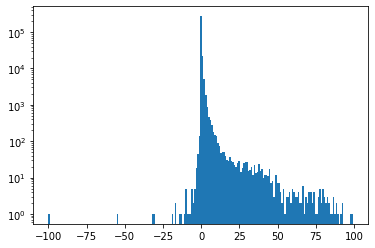

In [6]:
plt.hist(diffs[~np.isnan(diffs)], bins = 200);
plt.yscale('log', nonposy='clip')

###### We use the scraped cast to get an median age of each cast, we do not use an average as the data contains a lot of outliers.

In [7]:
people_file = people_file.explode('primaryProfession')
cast = cast.explode('cast')
people_year = people_file.drop(['primaryName', 'deathYear', 'primaryProfession', 'knownForTitles'], axis=1)
cast = cast.merge(people_year, how='inner', left_on = 'cast', right_on = 'nconst')

We make a new feature; when the year is missing in the scraped file we take the year from the scraping

In [8]:
movies['Year'] = np.where(np.isnan(movies['startYear']), movies['testYear'], movies['startYear'])
movies_year = movies[['tconst', 'Year']]

cast = cast.merge(movies_year, how='inner', on = 'tconst')

Sanity check

In [9]:
cast['cast'].isna().sum()

0

In [10]:
cast['tconst'].isna().sum()

0

We remove the duplicates

In [11]:
(cast[['tconst', 'cast']].duplicated()).sum()

4120666

In [12]:
cast = cast.drop_duplicates(subset=['tconst', 'cast'])

###### We remove the obvious outliers like birthYear < 1800

In [13]:
cast['birthYear'] = np.where(cast['birthYear'] < 1800, np.nan, cast['birthYear'])

We introduce the Age variable, we compute it from the Year of the movies file/scraping and the birthYear of people file

In [14]:
cast['Age'] = cast['Year'] - cast['birthYear']

We check for outliers

In [15]:
(cast['Age'] < 0).sum()

530

In [16]:
(cast['Age'] > 100).sum()

6737

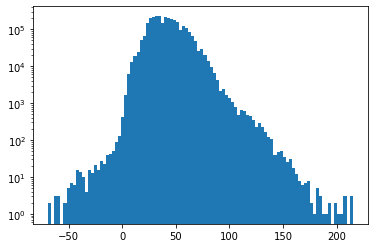

In [17]:
ages = cast['Age'].values
plt.hist(ages[~np.isnan(ages)], bins=100);
plt.yscale('log', nonposy='clip')

In [22]:
cast_ages = cast.groupby(['tconst'])['Age'].agg([np.nanmedian, cast_count])
cast_ages = cast_ages.rename(columns={'nanmedian': 'custom_median'})

In [23]:
cast_ages.head()

,custom_median,cast_count
tconst,,
tt0000009,19.0,3.0
tt0000147,39.0,5.0
tt0000335,11.0,2.0
tt0000502,NaN,0.0
tt0000574,28.0,6.0


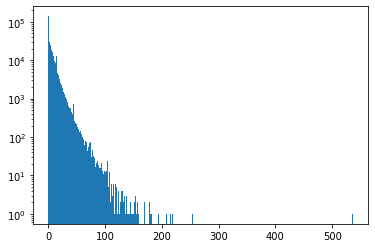

In [24]:
plt.hist(cast_ages['cast_count'], bins=500);
plt.yscale('log', nonposy='clip')

We only take the information if we have more than 10 persons in the cast

In [25]:
cast_ages['credible_median'] = np.where(cast_ages['cast_count'] > 10, cast_ages['custom_median'], np.nan)

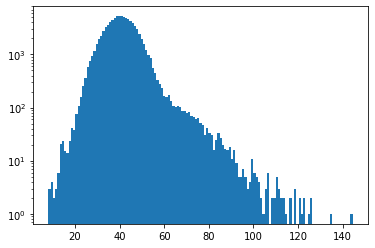

In [26]:
credible_median_ages = cast_ages['credible_median'].values
plt.hist(credible_median_ages[~np.isnan(credible_median_ages)], bins = 135);
plt.yscale('log', nonposy='clip')

We see that we do not have the negative age outliers but we still have suspiciously high values

In [27]:
cast_ages.nlargest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt6454944,144.5,30.0,144.5
tt6490038,135.0,11.0,135.0
tt1646939,126.0,11.0,126.0
tt3587202,126.0,17.0,126.0
tt0212457,125.0,11.0,125.0
tt3188516,123.0,13.0,123.0
tt3526810,123.0,13.0,123.0
tt10443162,122.0,43.0,122.0
tt2161168,121.0,20.0,121.0


The high values come from recent documentaries using archive footage or reconstruction of very old films.

In [28]:
cast_ages.nsmallest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt0201347,8.0,27.0,8.0
tt0008144,9.0,17.0,9.0
tt0110366,9.0,34.0,9.0
tt0007617,9.5,14.0,9.5
tt0009721,9.5,14.0,9.5
tt0117008,10.0,44.0,10.0
tt0124879,10.0,35.0,10.0
tt0007669,11.0,14.0,11.0
tt0022397,11.0,16.0,11.0


Legit values

# Creation of success metrics

### Recognition 

In [29]:
OSCAR_WEIGHT = 10
WIN_WEIGHT = 2
NOMINATION_WEIGHT = 1
movies['recognition'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) \
                        + (movies.wins * WIN_WEIGHT)
recognized_movies = movies.sort_values('recognition', ascending=False)
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,musicProducer,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,nm0001877,12 Years a Slave,12 Years a Slave,0.0,2013.0,134.0,NaN,2014.0,2013.0,836
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,nm3225654,La La Land,La La Land,0.0,2016.0,128.0,NaN,2016.0,2016.0,794
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,nm1615109,Moonlight,Moonlight,0.0,2016.0,111.0,NaN,2016.0,2016.0,757
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,nm0432725,Mad Max: Fury Road,Mad Max: Fury Road,0.0,2015.0,120.0,NaN,2015.0,2015.0,744
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,nm1888527,Gravity,Gravity,0.0,2013.0,91.0,NaN,2013.0,2013.0,713


In [30]:
recognized_movies = recognized_movies.merge(cast_ages, how='left', left_on='tconst', right_index=True)
recognized_movies = recognized_movies.drop_duplicates(subset=['tconst'])
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition,custom_median,cast_count,credible_median
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,0.0,2013.0,134.0,NaN,2014.0,2013.0,836,42.5,32.0,42.5
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,0.0,2016.0,128.0,NaN,2016.0,2016.0,794,36.5,54.0,36.5
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,0.0,2016.0,111.0,NaN,2016.0,2016.0,757,37.0,5.0,NaN
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,0.0,2015.0,120.0,NaN,2015.0,2015.0,744,40.0,25.0,40.0
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,0.0,2013.0,91.0,NaN,2013.0,2013.0,713,53.0,4.0,NaN


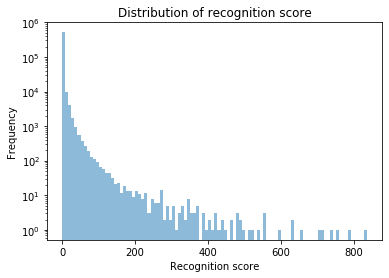

In [31]:
fig, ax = plt.subplots()
recognized_movies.recognition.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of recognition score')
ax.set_xlabel('Recognition score');

### Popularity  

We directly use the number of votes form the imdb website, we got it from ratings file from imdb

In [32]:
recognized_movies = recognized_movies.merge(movie_ratings, on='tconst', how='left')

### Revenue

We only use the revenue expressed in US dollars (the majority) as it is hard to find conversion rates before 2000. We use the easymoney library to take into account the inflation.

In [33]:
recognized_movies['worldwideGross_adjusted'] = recognized_movies['worldwideGross'].apply(keep_numbers)
ep = EasyPeasy()
recognized_movies['worldwideGross_adjusted'] = normalize_inflation(recognized_movies['worldwideGross_adjusted'],\
                                                                   recognized_movies['Year'])

/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2019.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2018.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2022.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2018.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2020.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2018.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


## Comparing the three success metrics with the median age of the cast 

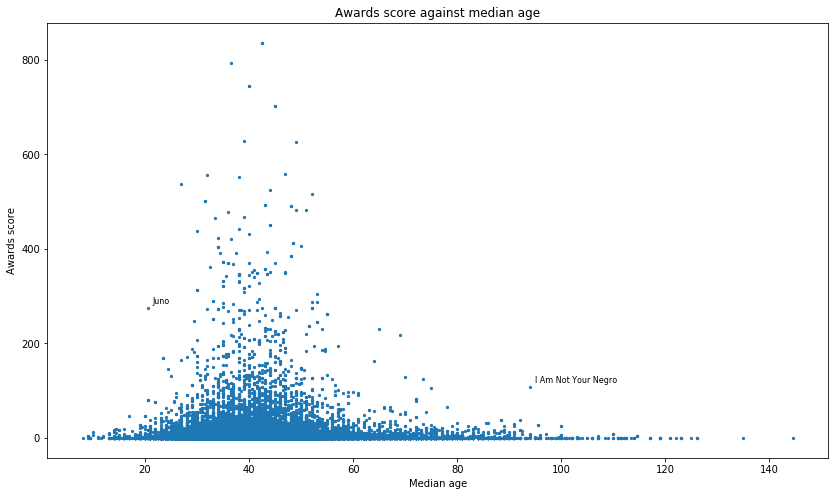

In [35]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against median age") 

annotations = []
annotations.append(recognized_movies[(recognized_movies['credible_median'] < 25) &\
                  (recognized_movies['recognition'] > 200)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])
annotations.append(recognized_movies[(recognized_movies['credible_median'] > 90) &\
                  (recognized_movies['recognition'] > 100)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])

for title, x, y in annotations:
    plt.text(x+1, y+10, title, fontsize=8)

#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

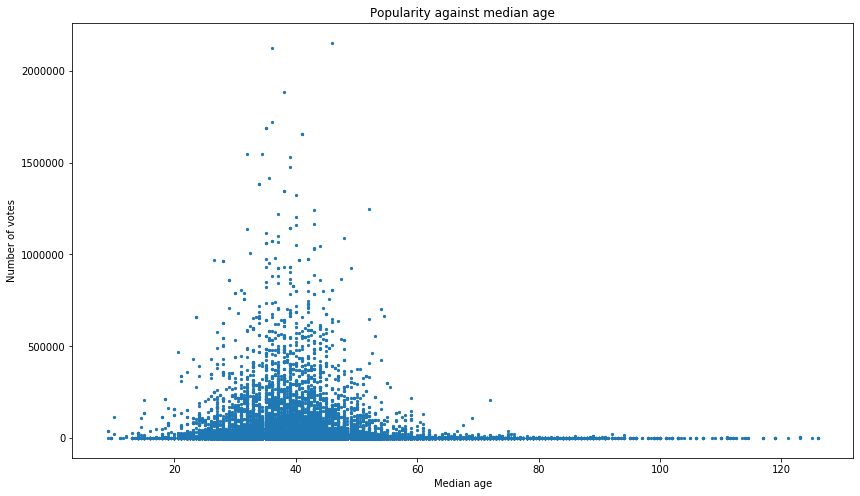

In [36]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against median age")  
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Number of votes');

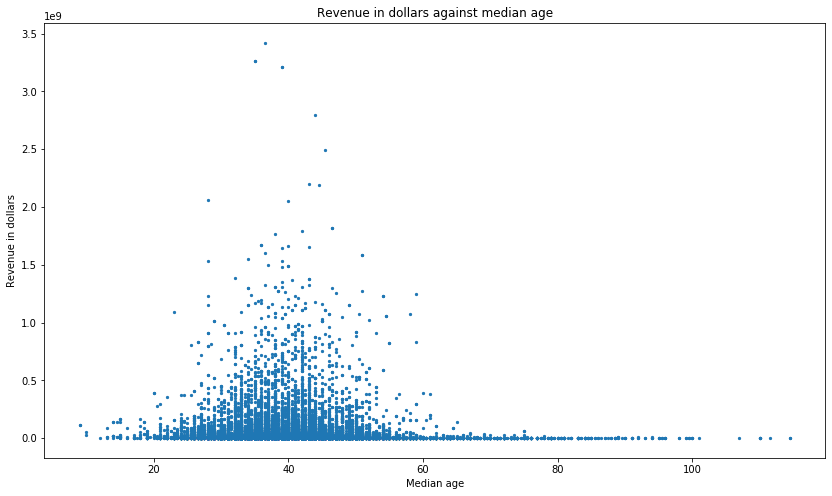

In [37]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against median age")
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Revenue in dollars');

# Trying to go more in-depth with more statistics for some age intervals

In [38]:
intervals = np.arange(20, 90, 10)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 150)
movies_stats = recognized_movies.groupby(pd.cut(recognized_movies['credible_median'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats = movies_stats.rename(columns={'<lambda_0>': '75%', '<lambda_1>': '90%', \
                                            '<lambda_2>': '95%','<lambda_3>': '99%'})

In [39]:
movies_stats['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
credible_median,,,,,,,,,,
"(0, 20]",248,3.076613,7.154044,0,47,0,3,9,17.00,37.54
"(20, 30]",7488,3.264824,15.213295,0,538,0,0,8,16.65,51.00
"(30, 40]",47526,3.490489,18.398615,0,794,0,0,8,16.00,59.00
"(40, 50]",49064,3.274927,18.096975,0,836,0,0,6,15.00,60.00
"(50, 60]",8437,3.637075,17.053491,0,517,0,0,8,17.00,66.00
"(60, 70]",1438,3.376912,12.990862,0,230,0,0,9,17.00,56.26
"(70, 80]",711,3.326301,10.140999,0,125,0,2,10,16.50,45.00
"(80, 150]",427,2.915691,8.218404,0,108,0,2,10,17.70,31.74


In [40]:
movies_stats['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
credible_median,,,,,,,,,,
"(0, 20]",233.0,14598.343348,38146.476922,7.0,214105.0,519.0,4579.0,40406.0,115313.40,191038.96
"(20, 30]",6776.0,10972.907320,51682.137452,5.0,971031.0,226.0,1978.0,16366.5,46546.25,229226.50
"(30, 40]",42785.0,11070.220381,61724.174596,5.0,2126738.0,174.0,1218.0,10472.0,43407.40,250970.92
"(40, 50]",44687.0,6999.394320,44176.815964,5.0,2153889.0,137.0,837.0,5839.0,21045.00,165032.38
"(50, 60]",7732.0,4087.909079,28617.139238,5.0,1245991.0,157.0,801.0,4175.0,10696.45,94412.62
"(60, 70]",1263.0,1620.030087,7409.416641,5.0,132869.0,111.0,546.0,2481.0,6373.00,26237.36
"(70, 80]",634.0,1264.307571,8707.124702,5.0,207825.0,106.5,515.0,1838.3,5079.35,18208.00
"(80, 150]",380.0,621.192105,1872.794914,5.0,21967.0,99.0,470.0,1427.7,2557.00,10881.59


In [41]:
movies_stats['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
credible_median,,,,,,,,,,
"(0, 20]",91.0,4.032998e+07,7.000282e+07,33102.56,3.881341e+08,1.221432e+07,3.533039e+07,1.353178e+08,1.541172e+08,3.881341e+08
"(20, 30]",1956.0,4.027418e+07,1.180451e+08,483.39,2.063267e+09,4.576286e+06,3.379935e+07,9.271842e+07,1.665044e+08,5.450699e+08
"(30, 40]",10609.0,5.403748e+07,1.579645e+08,0.00,3.421994e+09,4.217037e+06,3.371477e+07,1.411023e+08,2.769024e+08,7.324322e+08
"(40, 50]",9292.0,4.531767e+07,1.392894e+08,37.32,2.797801e+09,3.271393e+06,2.321982e+07,1.095509e+08,2.297256e+08,7.440602e+08
"(50, 60]",1894.0,2.935710e+07,1.208058e+08,99.39,1.583122e+09,1.667528e+06,9.167173e+06,4.369420e+07,1.126804e+08,5.897151e+08
"(60, 70]",381.0,6.575293e+06,2.961579e+07,607.96,3.787216e+08,2.363985e+05,1.173752e+06,8.608385e+06,2.197141e+07,1.572534e+08
"(70, 80]",214.0,1.708463e+06,7.154872e+06,35.12,6.509734e+07,1.353597e+05,5.569895e+05,2.159030e+06,5.193727e+06,2.936966e+07
"(80, 150]",113.0,7.500236e+05,1.981400e+06,382.91,1.211930e+07,1.131150e+05,5.148790e+05,1.084341e+06,3.557522e+06,1.171273e+07


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


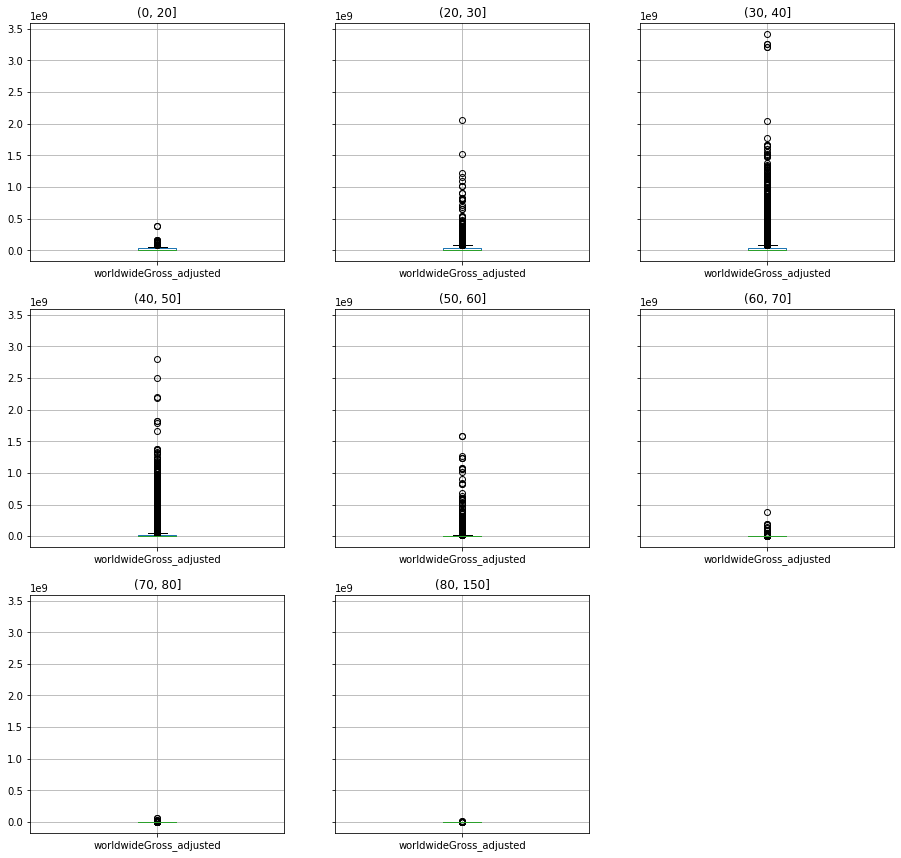

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
recognized_movies.groupby(pd.cut(recognized_movies['credible_median'], intervals))\
                 .boxplot(column=['worldwideGross_adjusted'], ax=ax);

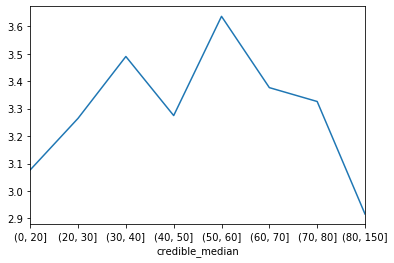

In [43]:
movies_stats['recognition']['nanmean'].plot()

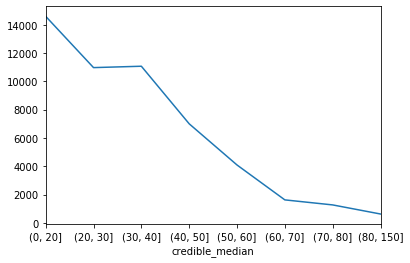

In [44]:
movies_stats['numVotes']['nanmean'].plot()

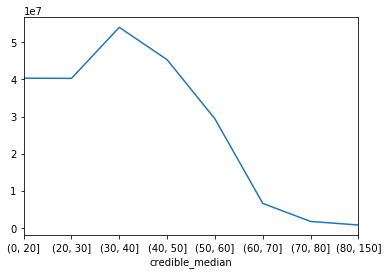

In [45]:
movies_stats['worldwideGross_adjusted']['nanmean'].plot()

# Metacritic score

In [46]:
clean_metascore = [lambda x: np.nan if x == None else int(x)]
recognized_movies['metascore'] = recognized_movies['metascore'].apply(clean_metascore)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


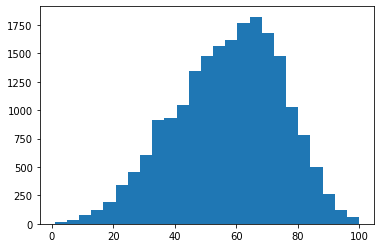

In [47]:
plt.hist(recognized_movies['metascore'], bins = 25);

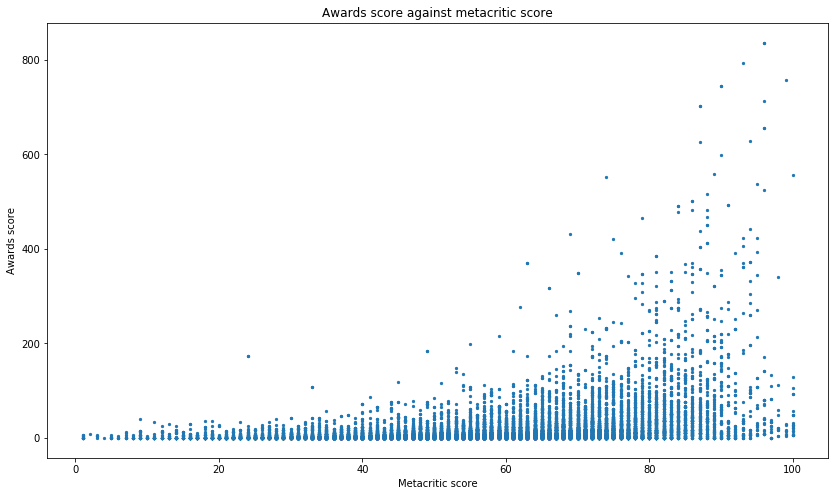

In [48]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

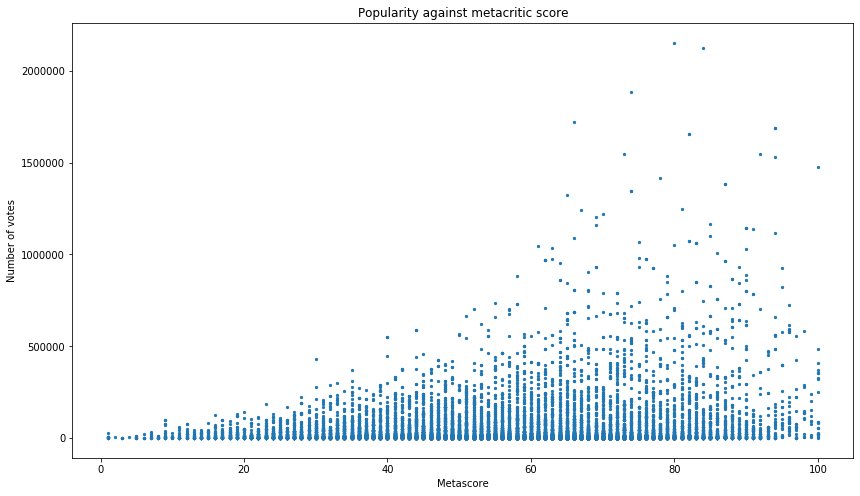

In [49]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against metacritic score")  
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Number of votes');

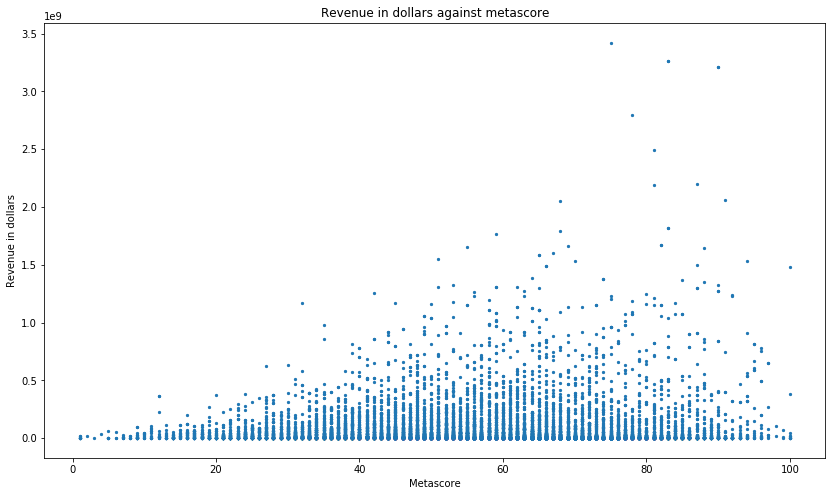

In [50]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against metascore")
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Revenue in dollars');

# isAdult

In [55]:
recognized_movies.groupby('isAdult')['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanmedian])

recognition                       numVotes                         \
         cast_count   nanmean nanmedian cast_count      nanmean nanmedian   
isAdult                                                                     
0.0          596696  1.333518         0   307397.0  3278.444149      48.0   
1.0            9886  0.143739         0     5205.0    39.898367      15.0   

        worldwideGross_adjusted                            
                     cast_count       nanmean   nanmedian  
isAdult                                                    
0.0                     55326.0  2.233228e+07  528639.015  
1.0                        10.0  7.771885e+04   43089.960

# runtimeMinutes

In [56]:
length_success = recognized_movies[['tconst', 'primaryTitle', 'runtimeMinutes', 'recognition', \
                                    'numVotes', 'worldwideGross_adjusted']]

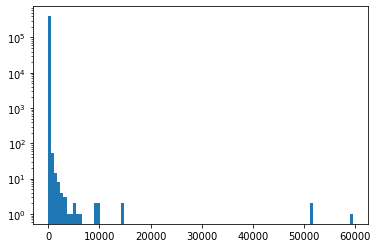

In [57]:
plt.hist(length_success['runtimeMinutes'], bins = 100);
plt.yscale('log', nonposy='clip')

In [58]:
length_success.nlargest(10, 'runtimeMinutes')[['tconst','primaryTitle', 'runtimeMinutes']]

,tconst,primaryTitle,runtimeMinutes
399886,tt10844584,100,59460.0
100142,tt8273150,Logistics,51420.0
100143,tt8273150,Logistics,51420.0
377635,tt2659636,Modern Times Forever,14400.0
377636,tt2659636,Modern Times Forever,14400.0
399880,tt10844900,Qw,10062.0
399881,tt10844900,Qw,10062.0
339117,tt2355497,Beijing 2003,9000.0
339118,tt2355497,Beijing 2003,9000.0
106922,tt5068890,Hunger!,6000.0


Even if the values are legit, we focus on the more conventional lengths

In [59]:
length_success = length_success[length_success['runtimeMinutes'] < 250]

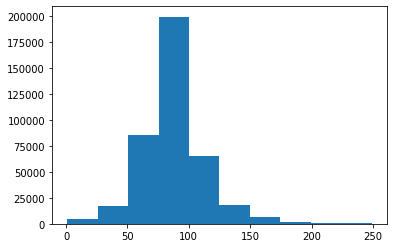

In [60]:
plt.hist(length_success['runtimeMinutes']);
#plt.yscale('log', nonposy='clip')

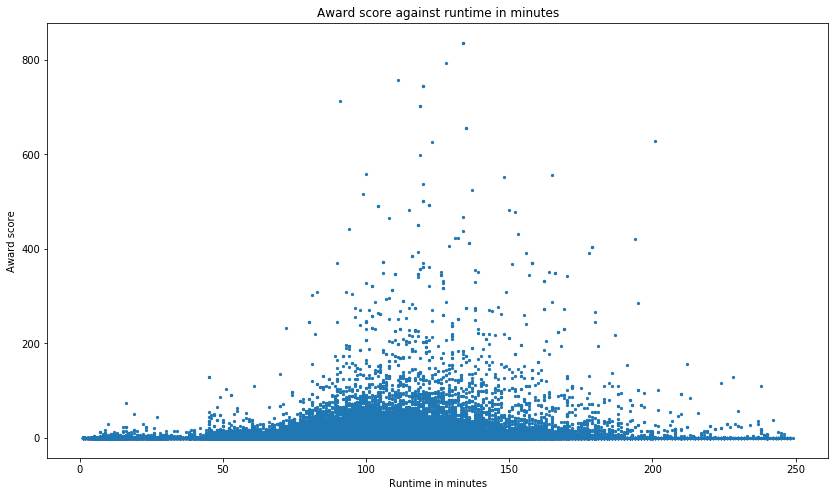

In [61]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['recognition'], s=5);

plt.title("Award score against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Award score');

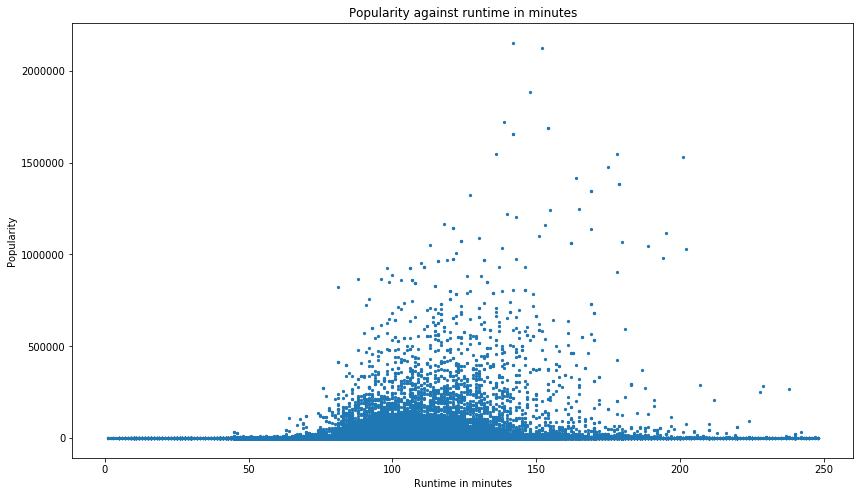

In [62]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['numVotes'], s=5);

plt.title("Popularity against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Popularity');

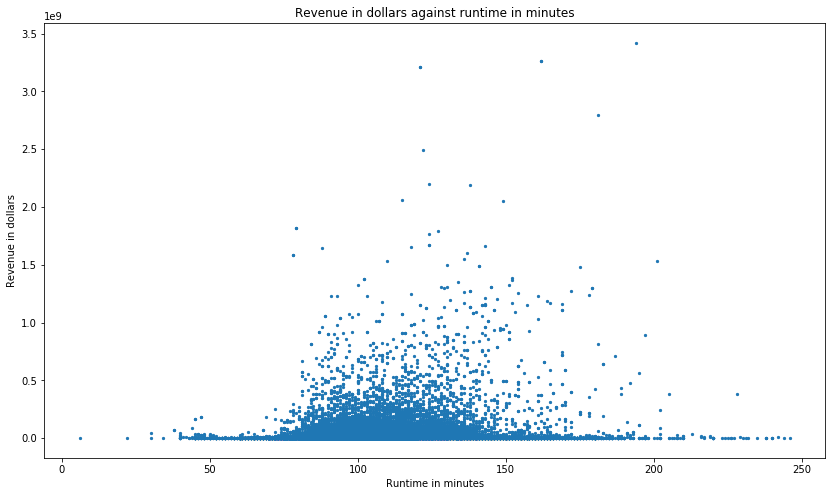

In [63]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Revenue in dollars');

# Trying to go more in-depth with more statistics for some runTime intervals

In [64]:
intervals = np.arange(0, 250+25, 25)
movies_stats_runtime = recognized_movies.groupby(pd.cut(recognized_movies['runtimeMinutes'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_runtime = movies_stats_runtime.rename(columns={'<lambda_0>': '75%', '<lambda_1>': '90%', \
                                            '<lambda_2>': '95%','<lambda_3>': '99%'})

In [65]:
movies_stats_runtime['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,
"(0, 25]",4808,0.198003,1.918319,0,75,0,0,0.0,0,6.00
"(25, 50]",17297,0.219344,2.453143,0,130,0,0,0.0,0,6.00
"(50, 75]",85078,0.331249,2.380787,0,232,0,0,0.0,0,9.00
"(75, 100]",199427,1.497149,6.988321,0,713,0,0,4.0,9,26.00
"(100, 125]",66825,4.367467,17.748371,0,757,0,2,12.0,22,61.00
"(125, 150]",17929,5.739919,26.206637,0,836,0,0,13.0,28,100.00
"(150, 175]",5854,5.779467,27.200348,0,556,0,0,11.0,24,110.00
"(175, 200]",1544,6.511658,28.735996,0,420,0,0,14.0,31,105.99
"(200, 225]",452,4.980088,32.739136,0,628,0,0,6.9,20,93.00


In [66]:
movies_stats_runtime['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,
"(0, 25]",346.0,29.609827,86.857477,5.0,1077.0,10.0,19.00,47.0,101.0,308.00
"(25, 50]",4863.0,102.727123,1000.177725,5.0,34937.0,14.0,32.00,98.0,228.6,1218.66
"(50, 75]",41842.0,184.897519,2034.536479,5.0,134792.0,22.0,67.00,213.0,472.0,2205.00
"(75, 100]",152834.0,1831.488694,15153.738001,5.0,928857.0,63.0,292.00,1350.0,3856.0,38286.23
"(100, 125]",54797.0,7956.857729,44200.350275,5.0,1166368.0,153.0,972.00,7266.0,28104.2,191947.40
"(125, 150]",14128.0,13967.815898,77278.926779,5.0,2153889.0,136.0,1080.00,9352.5,48042.0,375064.00
"(150, 175]",4876.0,12957.367104,90911.226354,5.0,2126738.0,164.0,1093.00,6559.0,20947.5,376742.00
"(175, 200]",1164.0,14479.926976,104186.618009,5.0,1545029.0,111.5,1100.75,9003.2,29286.7,297046.00
"(200, 225]",337.0,11538.130564,102335.505533,5.0,1529752.0,64.0,329.00,4279.0,15228.4,165674.88


In [67]:
movies_stats_runtime['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,
"(0, 25]",2.0,6.183180e+05,3.945104e+05,339357.00,8.972790e+05,618318.000,7.577985e+05,8.414868e+05,8.693829e+05,8.916998e+05
"(25, 50]",110.0,1.500416e+07,3.415754e+07,615.48,1.791959e+08,670241.185,1.676970e+07,3.338907e+07,6.886404e+07,1.775403e+08
"(50, 75]",1579.0,2.320398e+06,1.294966e+07,15.69,2.543084e+08,33190.470,5.050440e+05,3.327863e+06,6.722089e+06,5.091327e+07
"(75, 100]",26000.0,1.281151e+07,6.148520e+07,13.77,1.814742e+09,324282.010,2.755526e+06,1.974084e+07,5.585787e+07,2.596821e+08
"(100, 125]",17372.0,3.121952e+07,1.063394e+08,0.00,3.213030e+09,1752497.565,1.369850e+07,7.426208e+07,1.665387e+08,4.938258e+08
"(125, 150]",4041.0,6.455426e+07,1.875108e+08,30.72,2.191172e+09,2346579.520,2.638386e+07,1.703832e+08,3.737019e+08,1.030798e+09
"(150, 175]",1035.0,6.381000e+07,2.360697e+08,43.03,3.265544e+09,754777.550,9.076590e+06,1.273384e+08,3.764803e+08,1.171720e+09
"(175, 200]",237.0,7.900650e+07,3.390729e+08,1494.28,3.421994e+09,1489766.620,9.156066e+06,6.792898e+07,4.406243e+08,1.294937e+09
"(200, 225]",42.0,5.792257e+07,2.426326e+08,888.26,1.529402e+09,1061819.230,1.405602e+07,3.369082e+07,2.366334e+08,1.058107e+09


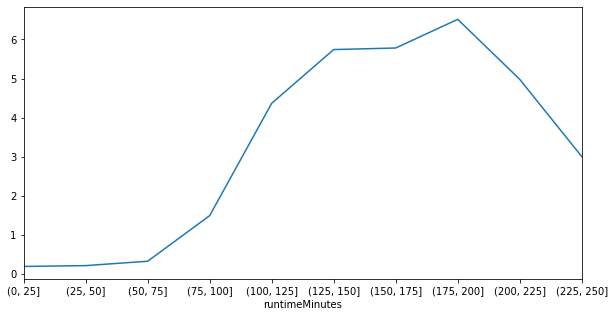

In [68]:
plt.figure(figsize=(10,5))
movies_stats_runtime['recognition']['nanmean'].plot();

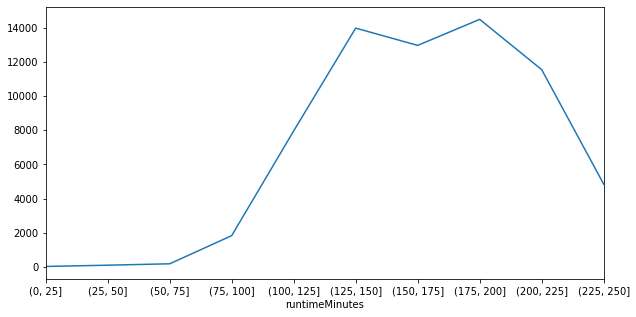

In [69]:
plt.figure(figsize=(10,5))
movies_stats_runtime['numVotes']['nanmean'].plot();

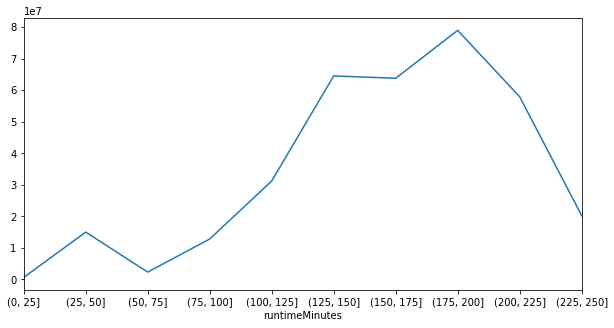

In [70]:
plt.figure(figsize=(10,5))
movies_stats_runtime['worldwideGross_adjusted']['nanmean'].plot();

# plotKeywords

In [71]:
top_keywords = recognized_movies.explode('plotKeywords').groupby('plotKeywords')\
                       ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                      .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [72]:
top_keywords[top_keywords['recognition']['cast_count'] > 100]

recognition                                       \
                              cast_count    nanmean      nanstd nanmin nanmax   
plotKeywords                                                                    
adultery                             131  31.450382   65.532401      0    361   
bare breasts                         297  23.350168   74.531500      0    627   
bare chested male                    105  51.161905  120.574197      0    703   
based on novel                       245  46.077551   90.593886      0    492   
based on true story                  157  73.751592  126.123599      0    836   
breasts                              262  18.801527   47.280920      0    361   
cleavage                             136  39.036765  105.497510      0    703   
coming of age                        135  51.437037  105.882476      0    757   
cult film                            200  22.910000   53.673421      0    361   
cunnilingus                          112  31.303571   76.851306      0    466   
death                                133  61.270677  100.246826      0    524   
erotica                              181   9.607735   35.055444      0    361   
father daughter relationship         120  60.900000   96.029267      0    394   
father son relationship              134  67.694030   96.961525      0    467   
fellatio                             120  25.433333   54.956474      0    422   
female frontal nudity                535  21.121495   54.797911      0    361   
female full frontal nudity           338  17.304734   53.699892      0    627   
female masturbation                  104  23.250000   81.784437      0    627   
female nudity                        898  22.347439   69.032909      0    744   
female protagonist                   145  82.931034  148.685801      0    744   
female pubic hair                    221  18.642534   43.371061      0    331   
female rear nudity                   319  26.840125   67.063868      0    627   
female removes her clothes           149  12.711409   40.516979      0    361   
friendship                           121  68.289256  123.959768      0    627   
gay                                  172  36.127907   80.861270      0    627   
husband wife relationship            137  51.992701   85.227593      0    437   
infidelity                           128  33.234375   62.983248      0    361   
leg spreading                        104  15.355769   37.835854      0    266   
lesbian                              155  27.922581   76.371234      0    599   
lesbian kiss                         134  37.664179  113.698318      0    703   
lesbian sex                          135  21.644444   80.984471      0    599   
lust                                 131  19.824427   49.201076      0    361   
male frontal nudity                  432  30.574074   87.707032      0    836   
male full frontal nudity             217  34.691244  107.641129      0    836   
male nudity                          333  31.828829   66.570355      0    599   
male pubic hair                      112  25.214286   44.619195      0    285   
male rear nudity                     174  29.482759   72.286658      0    627   
masturbation                         153  37.843137   99.695201      0    627   
mother son relationship              130  58.923077  109.143858      0    757   
murder                               196  32.693878   68.486856      0    517   
neo noir                             115  66.904348  113.650817      0    552   
nudity                               337  23.068249   73.824628      0    655   
oral sex                             133  23.488722   48.740596      0    309   
panties                              175  17.211429   49.594052      0    367   
prostitute                           127  26.519685   80.292012      0    501   
pubic hair                           276  22.119565   55.941627      0    627   
public nudity                        103  25.815534   61.332

Almost all keywords are porn-related

In [73]:
top_keywords2 = recognized_movies[recognized_movies['isAdult'] == 0.0]\
              .explode('plotKeywords').groupby('plotKeywords')\
                       ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                      .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

In [74]:
top_keywords2 = top_keywords2[top_keywords2['recognition']['cast_count'] > 10]
top_keywords2 = top_keywords2['recognition'].sort_values('cast_count', ascending=False)

In [75]:
top_keywords2.head(20)

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,<lambda_0>,<lambda_1>,<lambda_2>,<lambda_3>
plotKeywords,,,,,,,,,,
female nudity,869,23.064442,70.061053,0,744,2.0,14.00,48.0,118.40,357.00
female frontal nudity,515,21.902913,55.703445,0,361,3.0,16.00,48.0,100.40,322.00
male frontal nudity,431,30.645012,87.796550,0,836,6.0,22.00,62.0,139.00,427.40
male nudity,331,31.978852,66.741402,0,599,9.0,32.00,79.0,151.50,356.20
female full frontal nudity,326,17.880368,54.591020,0,627,2.0,12.50,35.0,78.50,239.25
nudity,318,24.402516,75.792313,0,655,2.0,14.00,55.3,124.45,359.30
female rear nudity,304,28.118421,68.445197,0,627,3.5,20.25,79.0,144.00,322.00
bare breasts,290,23.913793,75.339023,0,627,2.0,13.00,40.0,126.55,364.63
pubic hair,271,22.476015,56.389702,0,627,2.0,18.00,77.0,106.00,252.00


# Frequency of each award

We try to define weights based on the frequency of each award

In [76]:
recognized_movies['oscarWins'].sum()

1433

In [77]:
recognized_movies['wins'].sum()

235457

In [78]:
recognized_movies['nominations'].sum()

312057

In [79]:
OSCAR_WEIGHT = recognized_movies['oscarWins'].sum() / recognized_movies['oscarWins'].sum()
WIN_WEIGHT = 1108 / recognized_movies['wins'].sum()
NOMINATION_WEIGHT = 1108 / recognized_movies['nominations'].sum()
movies['recognition2'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) + (movies.wins *WIN_WEIGHT)
recognized_movies2 = movies.sort_values('recognition2', ascending=False)
recognized_movies2

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition,recognition2
253088,tt0167260,"[nm0000704, nm0001557, nm0005212]",11,122,198,2003-12-17,Sweden,"[orc, epic, battle, journey, hobbit]","$94,000,000","$1,120,424,614",...,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0.0,2003.0,201.0,NaN,2003.0,2003.0,628,12.364914
236609,tt0120338,"[nm0000138, nm0000701, nm0000708]",11,80,115,1997-12-19,USA,"[iceberg, told in flashback, titanic, ship, sh...","$200,000,000","$2,187,463,944",...,Titanic,Titanic,0.0,1997.0,194.0,NaN,1997.0,1997.0,420,11.825211
187906,tt0052618,"[nm0000032, nm0370144, nm0000963]",11,13,17,1960-10-06,Netherlands,"[roman empire, ancient rome, roman, revenge, c...","$15,000,000","$74,427,638",...,Ben-Hur,Ben-Hur,0.0,1959.0,212.0,NaN,1960.0,1959.0,157,11.126156
244527,tt0055614,"[nm0000081, nm0001995, nm0000937]",10,10,18,1962-03-29,Netherlands,[],"$6,000,000","$44,061,777",...,West Side Story,West Side Story,0.0,1961.0,153.0,NaN,1962.0,1961.0,146,10.120210
234175,tt0116209,"[nm0000146, nm0000300, nm0000353]",9,75,54,1996-12-06,USA,"[patient, nurse, flashback, english, church, d...","$27,000,000","$231,976,425",...,The English Patient,The English Patient,0.0,1996.0,162.0,NaN,1996.0,1996.0,273,9.520408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189271,tt0054356,"[nm0088946, nm0127113, nm0353757]",0,0,0,1961-01-20,Finland,[],None,None,...,Susanne,Susanne,0.0,1960.0,87.0,NaN,1961.0,1960.0,0,0.000000
189270,tt0054308,"[nm0310618, nm0865063, nm0051060]",0,0,0,1960-11-23,Yugoslavia,[],None,None,...,Signal Over the City,Signali nad gradom,0.0,1960.0,91.0,NaN,1960.0,1960.0,0,0.000000
189268,tt0054304,"[nm0496856, nm0466977, nm0266949]",0,0,0,1961-03-11,Italy,[],None,None,...,Blood Feud,Il sicario,0.0,1961.0,87.0,NaN,1961.0,1961.0,0,0.000000
189267,tt0054332,[],0,0,0,None,None,[],None,None,...,Spartakiáda,Spartakiáda,0.0,1956.0,88.0,NaN,NaN,1956.0,0,0.000000


In [80]:
recognized_movies2 = recognized_movies2.merge(cast_ages, how='left', left_on='tconst', right_index=True)
recognized_movies2 = recognized_movies2.drop_duplicates(subset=['tconst'])

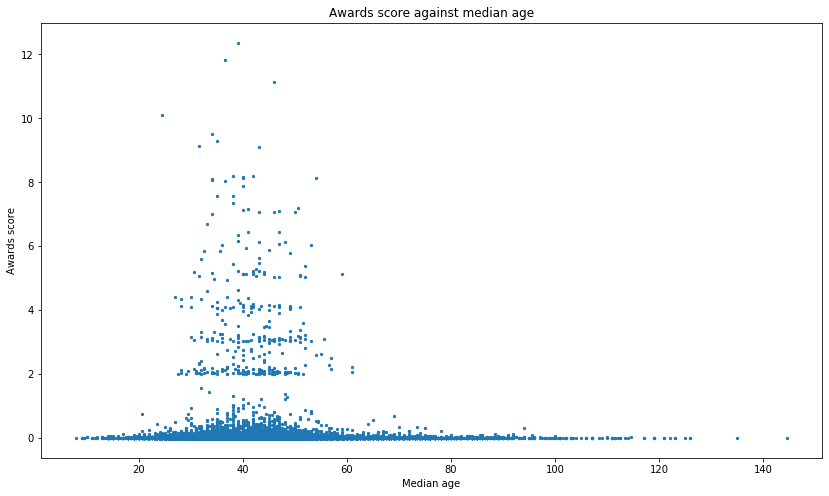

In [81]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies2['credible_median'],\
            recognized_movies2['recognition2'], s=5);
plt.title("Awards score against median age") 


#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

In [82]:
recognized_movies2['metascore'] = recognized_movies2['metascore'].apply(clean_metascore)

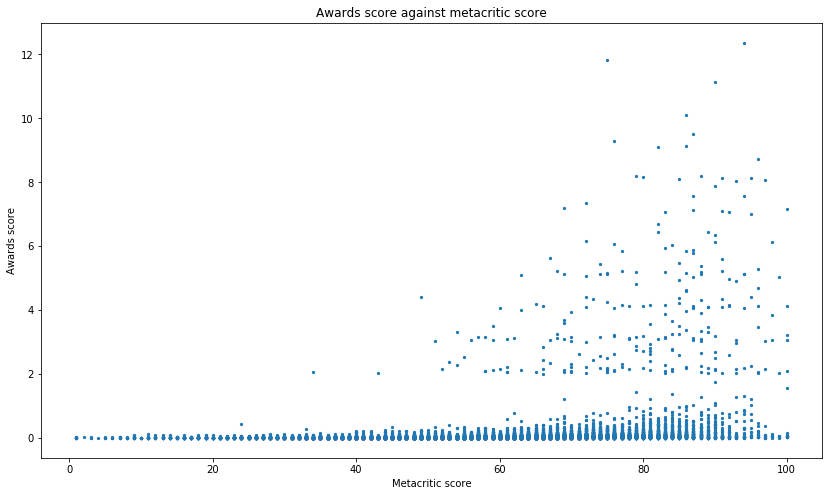

In [83]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies2['metascore'],\
            recognized_movies2['recognition2'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

# Correlation between the 3 success metrics

In [84]:
recognized_movies.corr()[['recognition', 'numVotes', 'worldwideGross_adjusted', 'averageRating', 'metascore']]

,recognition,numVotes,worldwideGross_adjusted,averageRating,metascore
oscarWins,0.431487,0.304884,0.300462,0.038065,0.154064
nominations,0.916927,0.537487,0.359989,0.097238,0.319802
wins,0.957375,0.448270,0.292322,0.121873,0.341582
metascore,0.347569,0.142388,0.053685,0.675437,1.000000
isAdult,-0.016302,-0.013654,-0.003025,-0.049930,-0.011594
startYear,0.087035,0.041723,-0.130094,0.035097,-0.108568
runtimeMinutes,0.020712,0.012714,0.150062,0.008551,0.149057
genres,NaN,NaN,NaN,NaN,NaN
testYear,0.089932,0.041444,-0.137217,0.014418,-0.096046
Year,0.086433,0.041711,-0.130332,0.035138,-0.108622
